In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy.stats as stats
import seaborn as sns
import datetime 
import statsmodels 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# A. Introduction - Research Proposal
For my final Thinkful capstone, I plan on creating a stock price predictor for some of the top S&P 500 companies in the tech industry. We will taking a closer look at Microsoft and Intel. (https://markets.businessinsider.com/index/components/s&p_500). 
The goal is to create a model that not only has a high accuracy score, but also one that provides a predicted price that is very close to the actual amount. 

Models of this kind would be incredibly beneficial for investors hoping to invest in top US stocks in tech. A model that considers seasonal trends for multiple companies will, hopefully, provide a sound forecast for smaller tech companies within the S&P dataset; an informed investment will naturally benefit investors in the form of high ROIs. 

For my data source, I will be using the S&P stock data kaggle set: https://www.kaggle.com/camnugent/sandp500#all_stocks_5yr.csv

The dataset has daily open, high, low, close and volume values for all S&P 500 stocks between February 7, 2013 and February 7, 2018. The lack of update in the past year can come in handy - when testing the model, I will juxtapose the predicted values and actual stock values between February 8 and February 20, 2018, two weeks after the last date listed on the data set. ARIMA modeling, supervised learning techniques (i.e. linear regression), as well as data visualization will be used for analysis, evaluating, and train-testing the predictor. We will also be using Facebook Prophet as a second model for performance comparison. 

# B. Preparing the Dataset
We are first going to drop all NaNs, create data subsets for Microsoft and Intel, and add a feature. The added feature is the mean of open, high, low and close prices (henceforth "ohlc") for any given day. 

In [2]:
df=pd.read_csv('all_stocks_5yr.csv',index_col='date',parse_dates=True)
data = df.dropna()
data.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [3]:
data.Name.unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'ADS', 'AEE', 'AEP', 'AES', 'AET', 'AFL',
       'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
       'ALLE', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMG', 'AMP',
       'AMT', 'AMZN', 'ANDV', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APC',
       'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATVI', 'AVB', 'AVGO', 'AVY',
       'AWK', 'AXP', 'AYI', 'AZO', 'A', 'BAC', 'BAX', 'BA', 'BBT', 'BBY',
       'BDX', 'BEN', 'BF.B', 'BHF', 'BHGE', 'BIIB', 'BK', 'BLK', 'BLL',
       'BMY', 'BRK.B', 'BSX', 'BWA', 'BXP', 'CAG', 'CAH', 'CAT', 'CA',
       'CBG', 'CBOE', 'CBS', 'CB', 'CCI', 'CCL', 'CDNS', 'CELG', 'CERN',
       'CFG', 'CF', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CINF', 'CI', 'CLX',
       'CL', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COG', 'COL', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CRM',
       'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS

In [4]:
data.dtypes

open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

In [5]:
#feature generation
data['Avg']=(data['open']+data['high']+data['low']+data['close'])/4
data.head()

,open,high,low,close,volume,Name,Avg
date,,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,14.8925
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.6550
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.3325
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.5375
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.2625


In [6]:
data_microsoft = data[data['Name']=='MSFT']
data_intel = data[data['Name']=='INTC']

data_intel.tail()

,open,high,low,close,volume,Name,Avg
date,,,,,,,
2018-02-01,47.695,48.47,47.4500,47.65,28840380,INTC,47.81625
2018-02-02,47.320,47.79,46.1000,46.15,28663029,INTC,46.84000
2018-02-05,46.350,47.26,44.5000,44.52,47869041,INTC,45.65750
2018-02-06,44.020,44.93,43.0302,44.91,58145381,INTC,44.22255
2018-02-07,44.580,46.30,44.3400,45.20,37508414,INTC,45.10500


# C. Exploratory Analysis and Data Visualizations

## Initial Observations

            open      high       low     close    volume       Avg
open    1.000000  0.999688  0.999677  0.999345 -0.364046  0.999825
high    0.999688  1.000000  0.999569  0.999668 -0.358308  0.999880
low     0.999677  0.999569  1.000000  0.999688 -0.370940  0.999881
close   0.999345  0.999668  0.999688  1.000000 -0.365311  0.999823
volume -0.364046 -0.358308 -0.370940 -0.365311  1.000000 -0.364689
Avg     0.999825  0.999880  0.999881  0.999823 -0.364689  1.000000


<function matplotlib.pyplot.show(*args, **kw)>

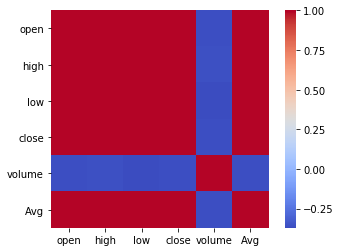

In [7]:
# As expected, both Microsoft (not shown) and Intel indicated high correlation between its ohlc and average values 
# this is substantiated by the pairplots for both stocks below
# using our initial observations, we will now run some linear graphs and regression
data_microsoft_corrmat = data_microsoft.corr()
print(data_microsoft_corrmat)
sns.heatmap(data_microsoft_corrmat,cmap="coolwarm",vmax=1,square=True)
plt.show

In [8]:
data_microsoft.describe()

,open,high,low,close,volume,Avg
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1259.000000
mean,51.026394,51.436007,50.630397,51.063081,3.386946e+07,51.038970
std,14.859387,14.930144,14.774630,14.852117,1.958979e+07,14.851874
min,27.350000,27.600000,27.230000,27.370000,7.425603e+06,27.422500
25%,40.305000,40.637500,39.870000,40.310000,2.254879e+07,40.201250
50%,47.440000,47.810000,47.005000,47.520000,2.938758e+07,47.380000
75%,59.955000,60.435000,59.275000,59.730000,3.842024e+07,59.864375
max,95.140000,96.070000,93.720000,95.010000,2.483542e+08,94.675325


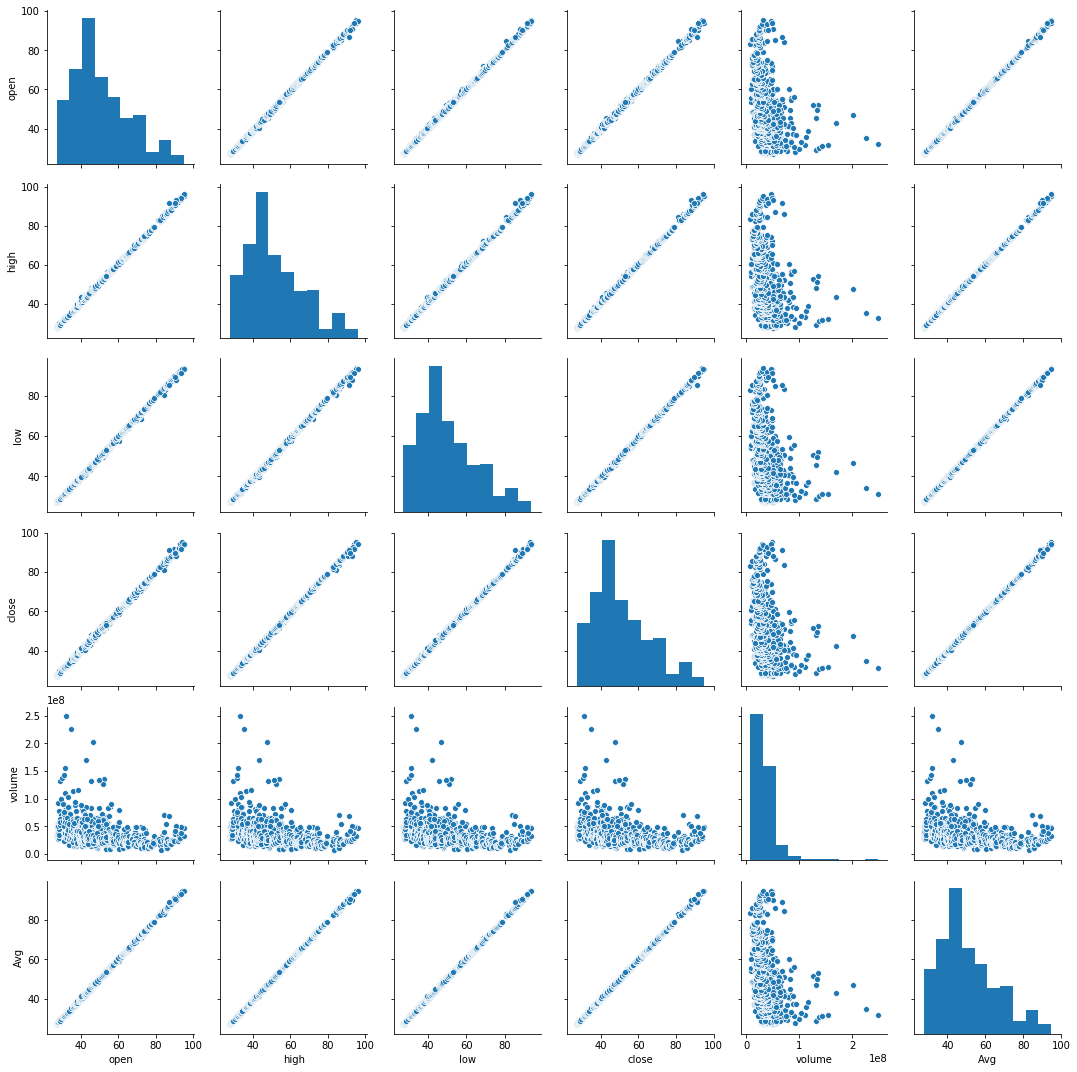

In [9]:
sns.pairplot(data_microsoft)

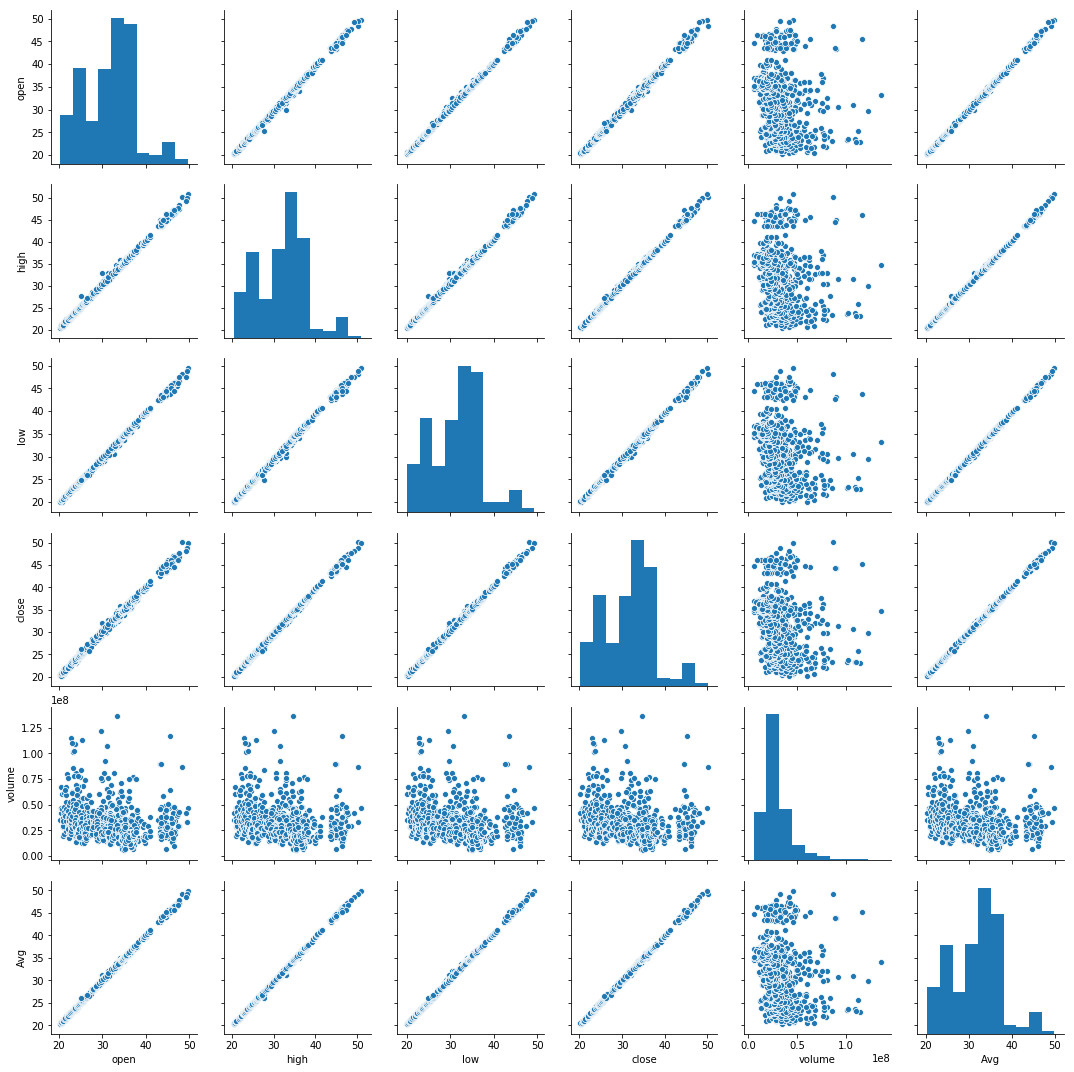

In [10]:
sns.pairplot(data_intel)

## Linear Relationship and Regression: Microsoft and Intel Prices Relationship/Correlation

(array([734869., 735234., 735599., 735964., 736330., 736695.]),
 <a list of 6 Text xticklabel objects>)

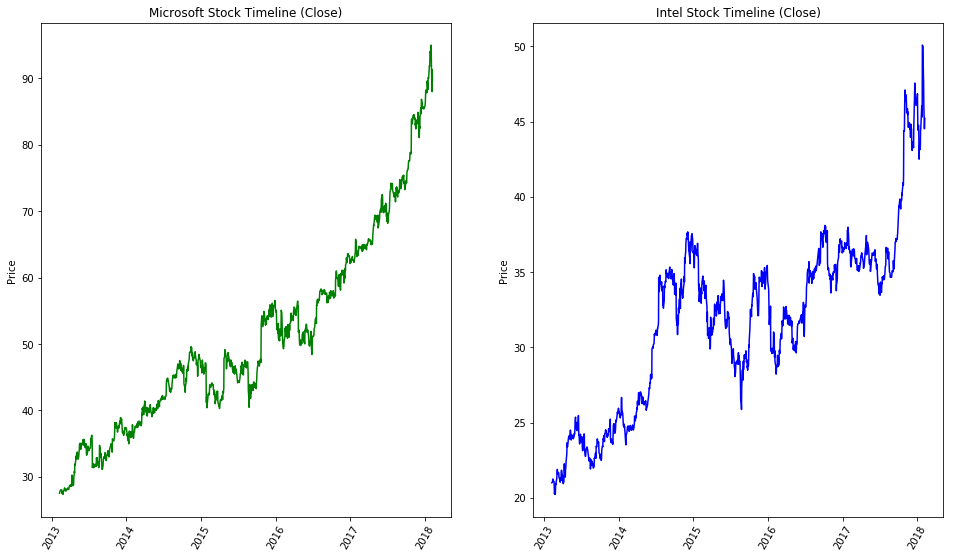

In [11]:
# we're now going to look at the historical timeline for both Microsoft and Intel stocks between February 2013 and 2018
data_microsoft_time = data_microsoft['close']
data_intel_time = data_intel['close']

plt.figure(figsize=(25,20))

plt.subplot(231)
plt.plot(data_microsoft_time, color='green')
plt.ylabel('Price')
plt.title('Microsoft Stock Timeline (Close)')
plt.xticks(rotation=60)

plt.subplot(232)
plt.plot(data_intel_time, color='blue')
plt.ylabel('Price')
plt.title('Intel Stock Timeline (Close)')
plt.xticks(rotation=60)

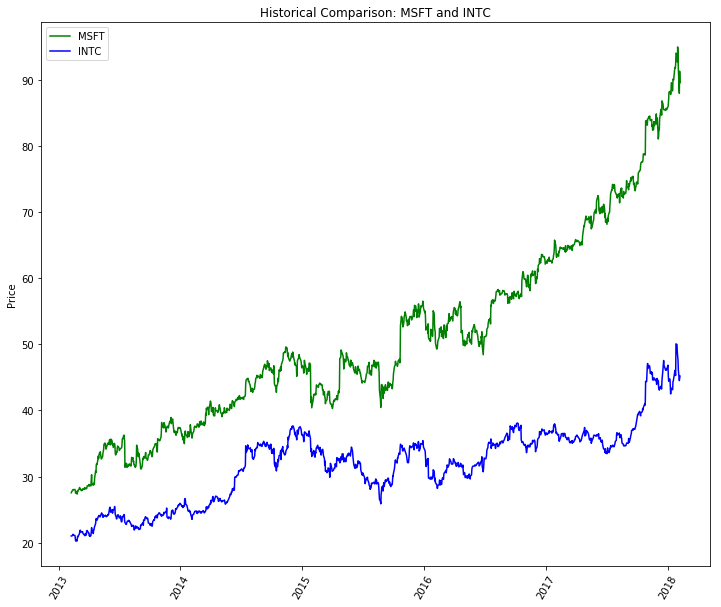

In [12]:
# juxtaposing the two timelines
# we can observe from the earlier subplots that while both stock prices have mild fluctuations, 
# they show an upward trend
plt.figure(figsize=(12,10))
plt.plot(data_microsoft_time, label='MSFT', color='green')
plt.plot(data_intel_time, label='INTC', color='blue')
plt.title('Historical Comparison: MSFT and INTC')
plt.ylabel('Price')
plt.xticks(rotation=60)
plt.legend()

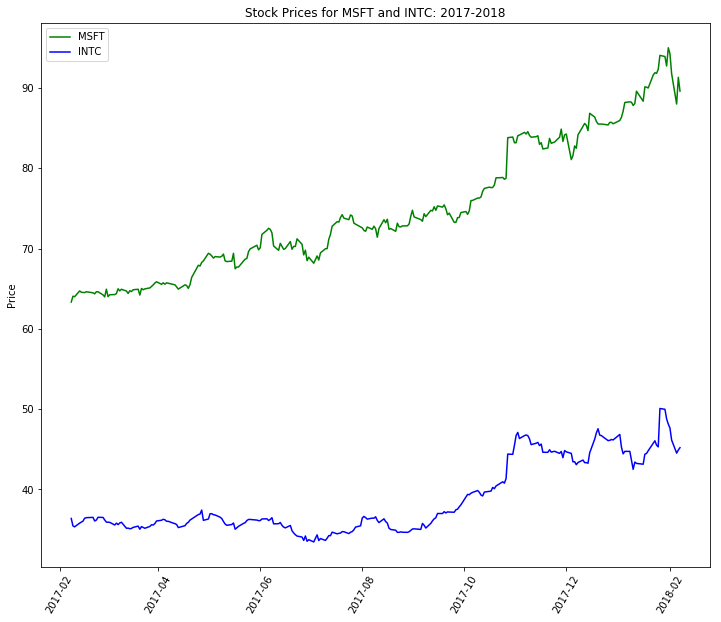

In [13]:
microsoft_time_closeup = data_microsoft['close'].loc['2017-02-08':]
intel_time_closeup = data_intel['close'].loc['2017-02-08':]

plt.figure(figsize=(12,10))
plt.plot(microsoft_time_closeup, label='MSFT', color='green')
plt.plot(intel_time_closeup, label='INTC', color='blue')
plt.title('Stock Prices for MSFT and INTC: 2017-2018')
plt.ylabel('Price')
plt.xticks(rotation=60)
plt.legend()

Alright - so there's a gap between the prices. We will see how they perform when both stock prices start at a 100. It's clear that Microsoft stock is rising faster than its counterpart. The regression graph indicates a positive correlation between both stocks. 

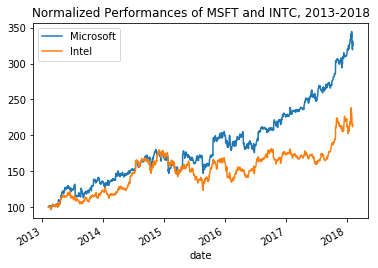

In [14]:
normalized_microsoft = data_microsoft_time.div(data_microsoft_time.iloc[0]).mul(100)
normalized_intel = data_intel_time.div(data_intel_time.iloc[0]).mul(100)
normalized_microsoft.plot()
normalized_intel.plot()
plt.title('Normalized Performances of MSFT and INTC, 2013-2018')
plt.legend(['Microsoft','Intel'])
plt.show()

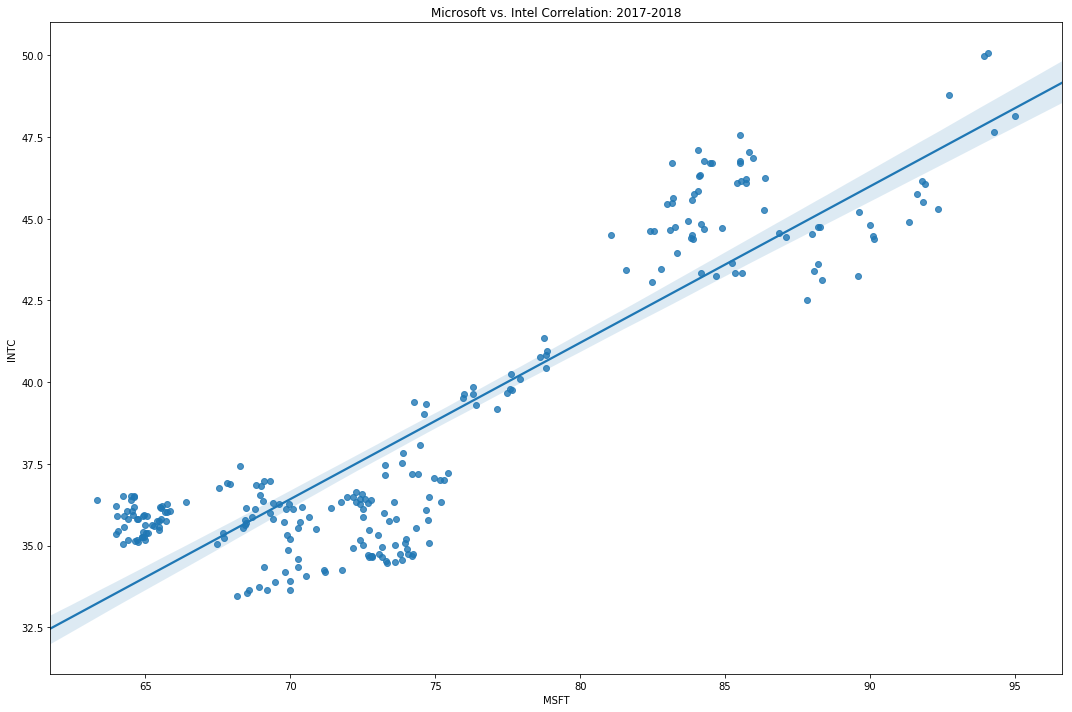

MSFT-Intel Reg: LinregressResult(slope=0.47852610848278904, intercept=2.9253663034160837, rvalue=0.8969020106199967, pvalue=1.4496373246629488e-90, stderr=0.0149223829955705)


In [15]:
plt.figure(figsize=(15,10))
sns.regplot(microsoft_time_closeup, intel_time_closeup)
plt.title('Microsoft vs. Intel Correlation: 2017-2018')
plt.xlabel('MSFT')
plt.ylabel('INTC')

plt.tight_layout()
plt.show()

print('MSFT-Intel Reg:', stats.linregress(microsoft_time_closeup[len(microsoft_time_closeup)-len(intel_time_closeup.dropna()):], intel_time_closeup.dropna()))

## Linear Regression: Relationship between Stock Price and Volume

Before proceeding with our time series modeling, we're going to observe the relationship between stock prices and volume traded, and determine the significance of the relationship. Below are timelines and regression graphs for both Microsoft and Intel. 

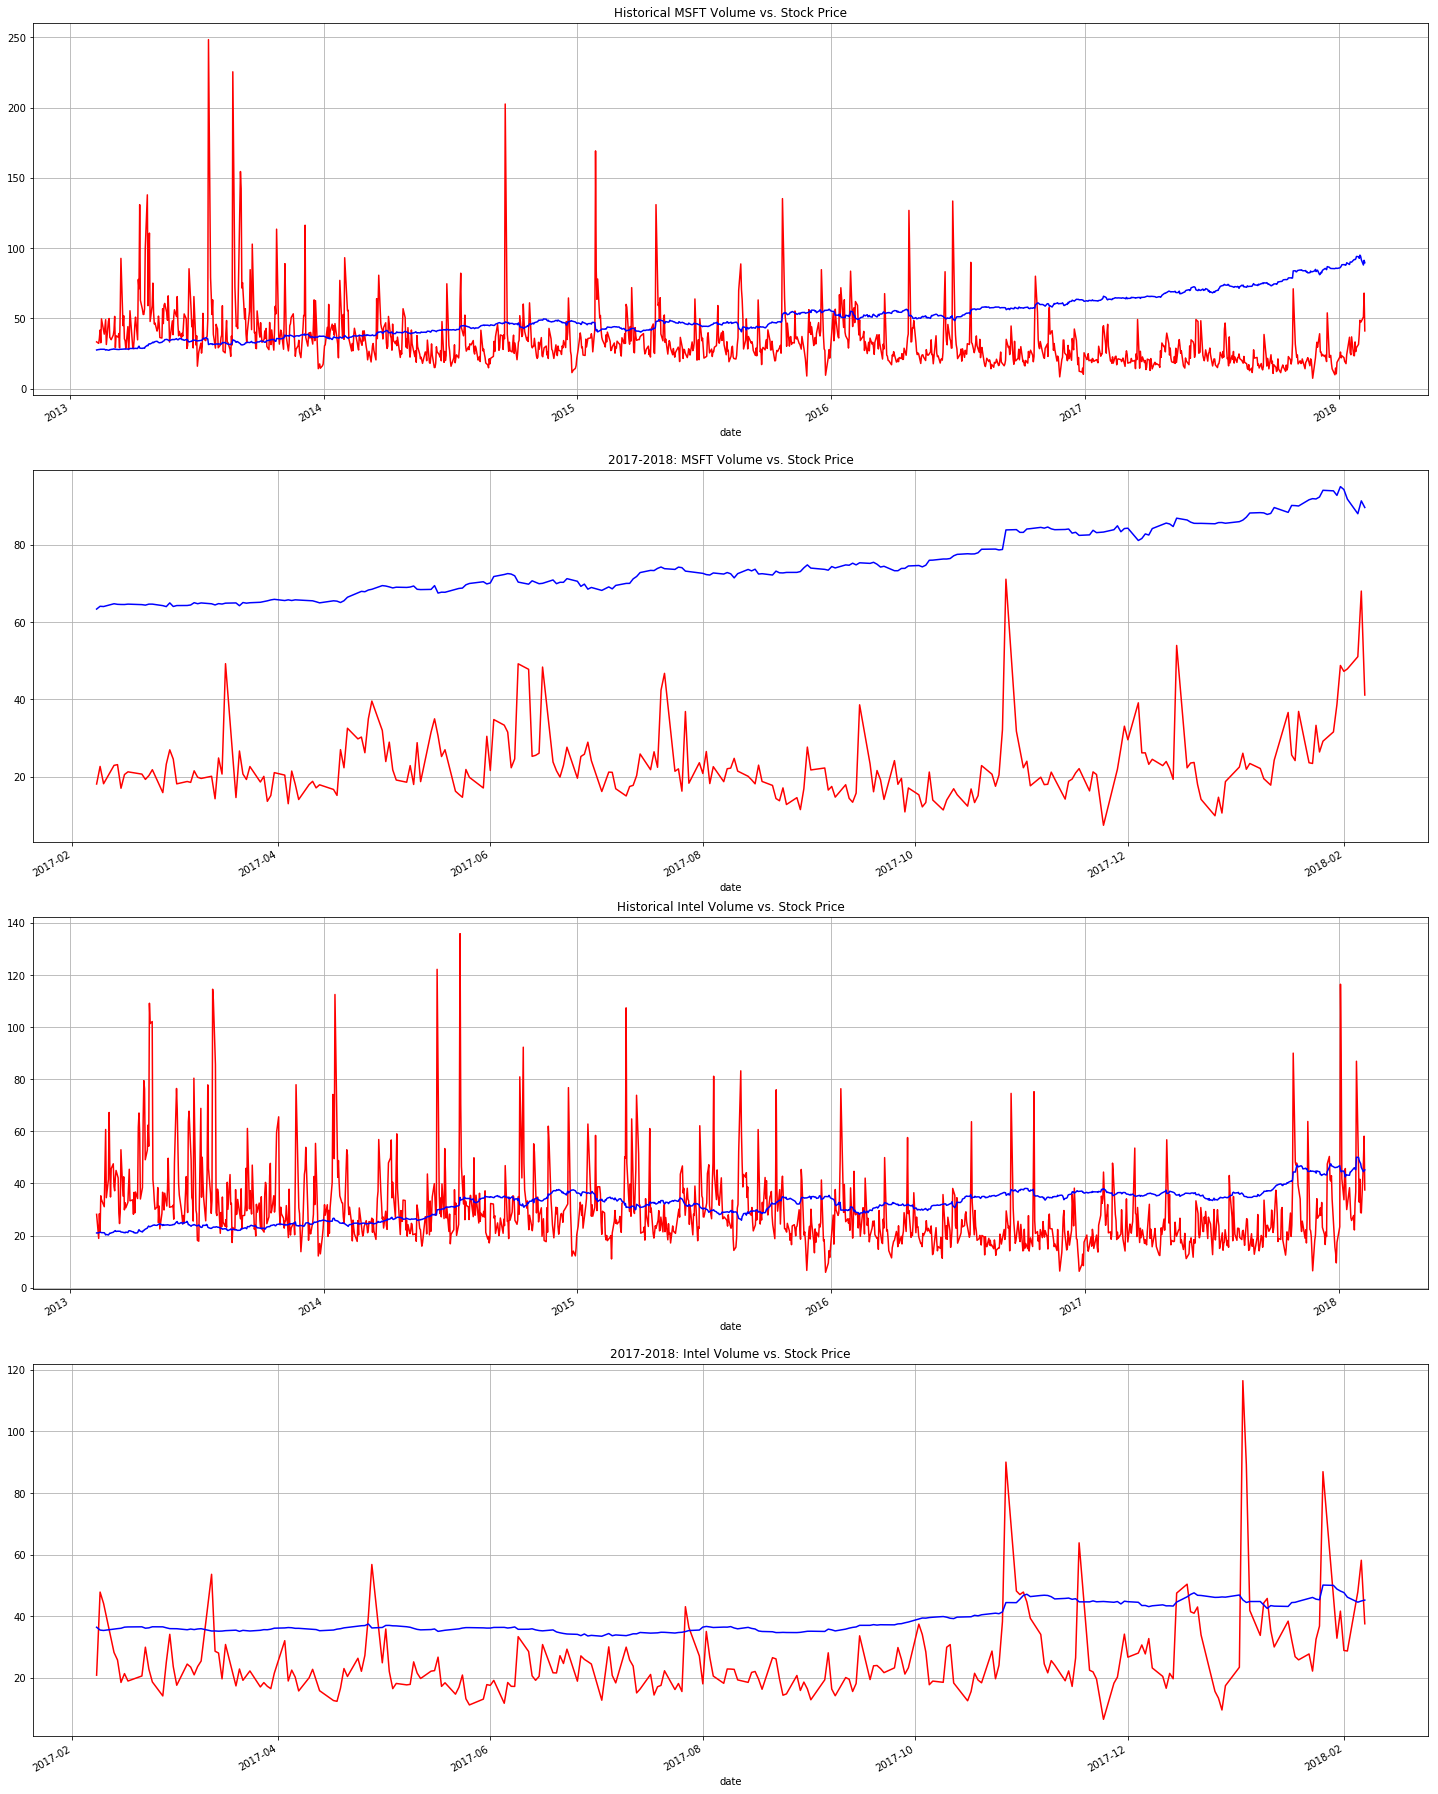

In [16]:
microsoft_volume = (data_microsoft['volume']/1000000).loc['2013-02-08':]
intel_volume = (data_intel['volume']/1000000).loc['2013-02-08':]
microsoft_volume_closeup = (data_microsoft['volume']/1000000).loc['2017-02-08':]
intel_volume_closeup = (data_intel['volume']/1000000).loc['2017-02-08':]

fig_year,(axy1,axy2,axy3,axy4)=plt.subplots(4,1,figsize=(25,35))
microsoft_volume.plot(color='red', title='Historical MSFT Volume vs. Stock Price', grid=True, ax=axy1)
data_microsoft_time.plot(color='blue', grid=True, ax=axy1)
microsoft_volume_closeup.plot(color='red', title='2017-2018: MSFT Volume vs. Stock Price', grid=True, ax=axy2)
microsoft_time_closeup.plot(color='blue', grid=True, ax=axy2)
intel_volume.plot(color='red', title='Historical Intel Volume vs. Stock Price', grid=True, ax=axy3)
data_intel_time.plot(color='blue', grid=True, ax=axy3)
intel_volume_closeup.plot(color='red', title='2017-2018: Intel Volume vs. Stock Price', grid=True, ax=axy4)
intel_time_closeup.plot(color='blue', grid=True, ax=axy4)
plt.show()

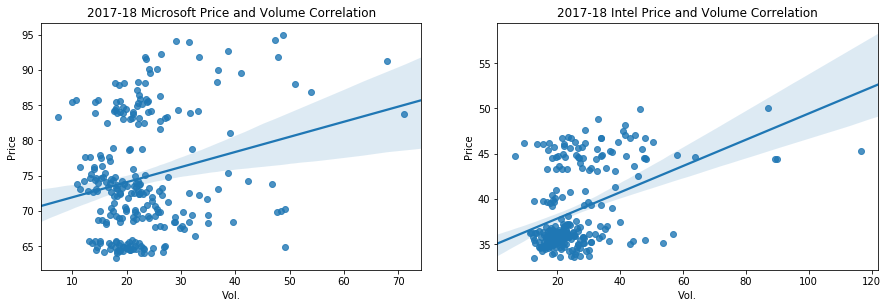

Microsoft Reg: LinregressResult(slope=0.21433278307238285, intercept=69.79248814746178, rvalue=0.23469562511092923, pvalue=0.00017004661954867132, stderr=0.05614494457287162)
Intel Reg: LinregressResult(slope=0.1450924540215769, intercept=34.937992811643724, rvalue=0.42760646881816233, pvalue=1.2647505840995608e-12, stderr=0.01939912615765753)


In [17]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.regplot(microsoft_volume_closeup, microsoft_time_closeup)
plt.title('2017-18 Microsoft Price and Volume Correlation')
plt.xlabel('Vol.')
plt.ylabel('Price')

plt.subplot(222)
sns.regplot(intel_volume_closeup, intel_time_closeup)
plt.title('2017-18 Intel Price and Volume Correlation')
plt.xlabel('Vol.')
plt.ylabel('Price')

plt.show()
print('Microsoft Reg:', stats.linregress(microsoft_volume_closeup[len(microsoft_volume_closeup)-len(microsoft_time_closeup.dropna()):], microsoft_time_closeup.dropna()))
print('Intel Reg:', stats.linregress(intel_volume_closeup[len(intel_volume_closeup)-len(intel_time_closeup.dropna()):], intel_time_closeup.dropna()))

## Summary Observations

To quickly recap what we have gathered from the data visualizations above: 
- Microsoft and Intel stock prices have a positive correlation; they also have a positive correlation with their respective traded volume. 
- This opens up a number of possibilities: instead of a univariate time series, which we have decided on for this project (using just the 'close' columns for MSFT and INTC), we can conduct multivariate time series by incorporating volume and all of ohlc. 
- Originally, the project intended to run tests with the 'Avg' column, which was added earlier as a part of feature generation. However, when juxtaposed with tests run with the 'close' column, it fared comparatively worse. 

# D. Seasonal Decomposition and Stationarity Tests

Let's prepare the dataset for ARIMA modeling by producing the following:
1. Seasonal Decomposition - helps us determine the presence of well-defined periodic patterns. 
2. Stationarity Test - to ensure that mean and variance of a dataset is stable through time/not time-dependent. We will use the Augmented Dickey-Fuller (ADF) test for testing stationarity. 

## Seasonal Decomposition for Microsoft & Intel

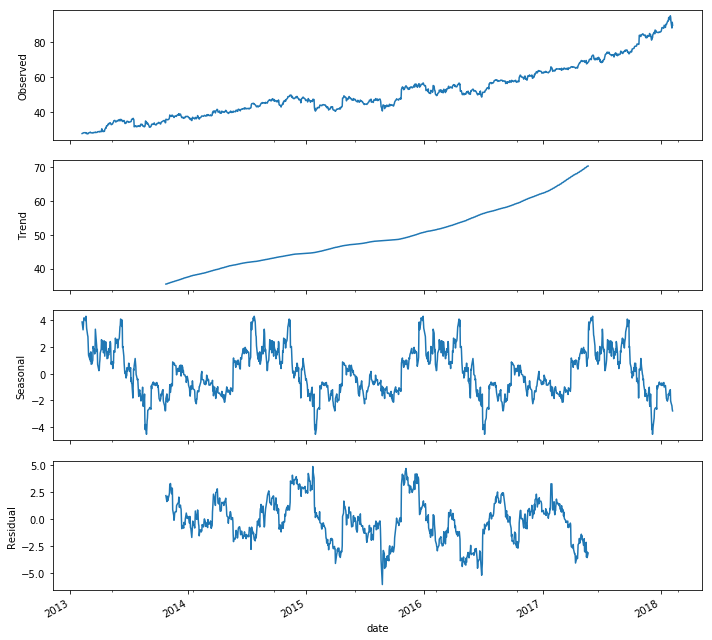

In [18]:
#MSFT seasonal decomposition
from pylab import rcParams
rcParams['figure.figsize'] = 10, 9
msft_decompose = seasonal_decompose(data_microsoft_time.dropna(),freq=360) # The frequncy is annual
figure = msft_decompose.plot()
plt.show()

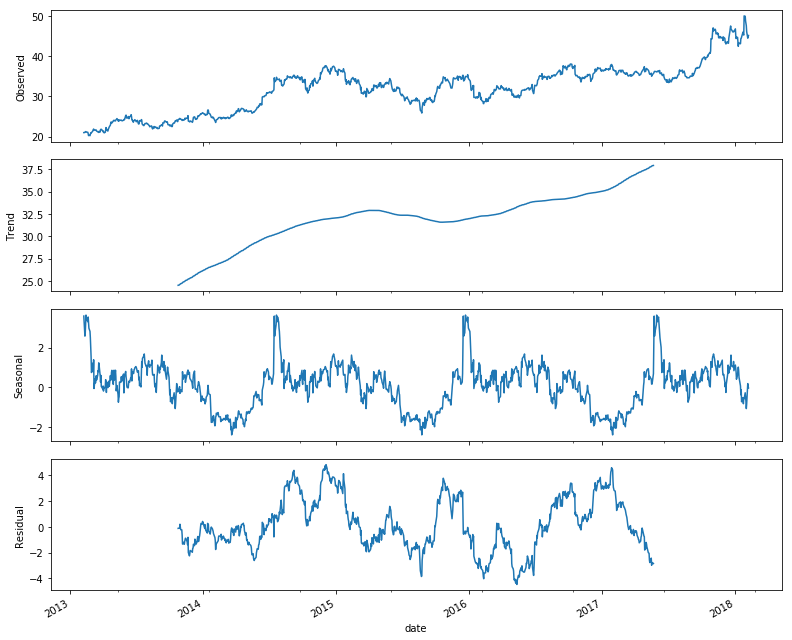

In [19]:
#Intel decomposition
rcParams['figure.figsize'] = 11, 9
intel_decompose = seasonal_decompose(data_intel_time.dropna(),freq=360) # The frequncy is annual
figure = intel_decompose.plot()
plt.show()

Both yearly decompositions appear similar - with an upward trend and both seasonal graphs show a cyclical pattern. 

## Model Config., Stationarity Testing and Differencing

Differencing the datasets if key should the raw dataset needs it. This is crucial for ARIMA modeling, which is observed at regular intervals and random movements instead of seasonality. Differencing subtracts a term in the dataset from its following term, creating a process where there is constant expected value. Below are two groups to illustrate my point. 

Text(0.5,1,'Intel (non-stationary)')

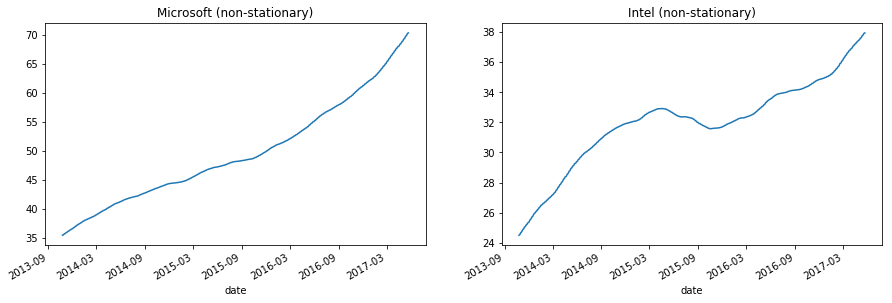

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
msft_decompose.trend.plot()
plt.title('Microsoft (non-stationary)')
plt.subplot(222)
intel_decompose.trend.plot()
plt.title('Intel (non-stationary)')

Text(0.5,1,'Intel (Stationary)')

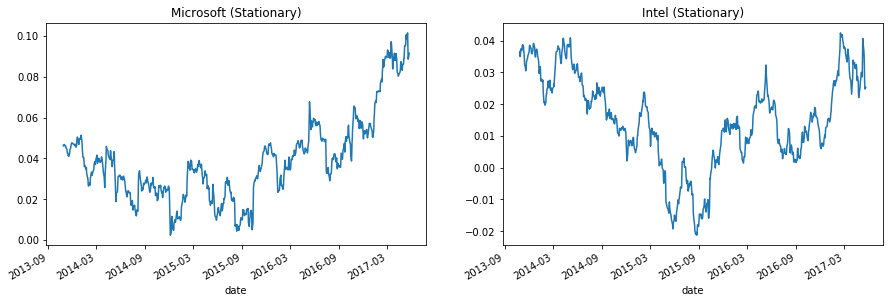

In [21]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
msft_decompose.trend.diff().plot()
plt.title('Microsoft (Stationary)')
plt.subplot(222)
intel_decompose.trend.diff().plot()
plt.title('Intel (Stationary)')

In [22]:
df = pd.DataFrame()
df['microsoft'] = data_microsoft_time
df['intel'] = data_intel_time
df.head()

,microsoft,intel
date,,
2013-02-08,27.55,21.00
2013-02-11,27.86,21.03
2013-02-12,27.88,21.19
2013-02-13,28.03,21.25
2013-02-14,28.04,21.23


In [23]:
df['msftdiff'] = df.microsoft - df.microsoft.shift(periods=1)
df['inteldiff'] = df.intel - df.intel.shift(periods=1)
df.head()

,microsoft,intel,msftdiff,inteldiff
date,,,,
2013-02-08,27.55,21.00,NaN,NaN
2013-02-11,27.86,21.03,0.31,0.03
2013-02-12,27.88,21.19,0.02,0.16
2013-02-13,28.03,21.25,0.15,0.06
2013-02-14,28.04,21.23,0.01,-0.02


We have created both graphs and tables for raw and differenced datasets - and are now going to create 4 15-day train-test sets. Two for Microsoft, two for Intel: 

In [24]:
# 15 day history (3 wks.)
msft_train15 = df.microsoft[:-15].dropna()
msft_test15 = df.microsoft[-15:]
print('MSFT train:', len(msft_train15), 
      '\nMSFT test:', len(msft_test15))

intel_train15 = df.intel[:-15].dropna()
intel_test15 = df.intel[-15:]
print('\nINTC train:', len(intel_train15), 
      '\nINTC test:', len(intel_test15))

# 15 day history (3 wks.) with differenced data
msftdiff_train15 = df.msftdiff[:-15].dropna()
msftdiff_test15 = df.msftdiff[-15:].dropna()
print('\nMSFT train:', len(msftdiff_train15), 
      '\nMSFT test:', len(msftdiff_test15))

inteldiff_train15 = df.inteldiff[:-15].dropna()
inteldiff_test15 = df.inteldiff[-15:].dropna()
print('\nINTC train:', len(inteldiff_train15), 
      '\nINTC test:', len(inteldiff_test15))

MSFT train: 1244 
MSFT test: 15

INTC train: 1244 
INTC test: 15

MSFT train: 1243 
MSFT test: 15

INTC train: 1243 
INTC test: 15


In [25]:
def stationarity_test(name, x):
    result = adfuller(x)
    print(name,':')
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])

In [26]:
stationarity_test('MSFT', msft_train15)
stationarity_test('\nINTC', intel_train15)
stationarity_test('\nMSFT (diff)', msftdiff_train15)
stationarity_test('\nINTC (diff)', inteldiff_train15)

MSFT :
ADF Statistic 0.671580
p-value: 0.989253

INTC :
ADF Statistic -1.123941
p-value: 0.705431

MSFT (diff) :
ADF Statistic -35.690547
p-value: 0.000000

INTC (diff) :
ADF Statistic -7.703259
p-value: 0.000000


Ooph, looks like we will need differencing for both Microsoft and Intel datasets. We will be mindful of this when we proceed to create our modeling. 

# E. ARIMA Modeling

In [27]:
#let's start with acf and pacf plots 
def autocorrelation_model(name, x):
    plot_acf(pd.Series(x), lags=50, alpha=0.05)
    plt.title('{} - Autocorrelation Function'.format(name))
    plt.show()

    plot_pacf(pd.Series(x), lags=50, alpha=0.05)
    plt.title('{} - Partial Autocorrelation Function'.format(name))
    plt.show()
    
#Observations
# Using lags of 50, we see similar outcomes for raw dataset for both ACF/PACF graphs for Microsof and Intel, with 
# high correlations in both for over 50 days in the ACF graph, and strong correlation for only one day in the PACF.
# differenced data yielded strong correlation for no days in both ACF and PACF graphs.

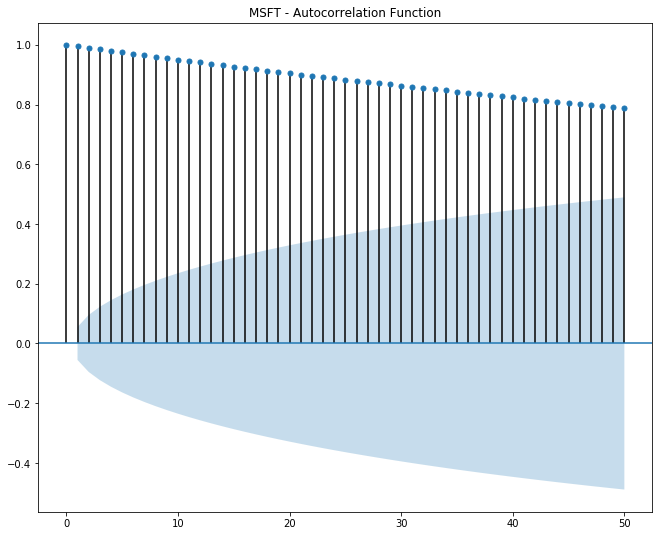

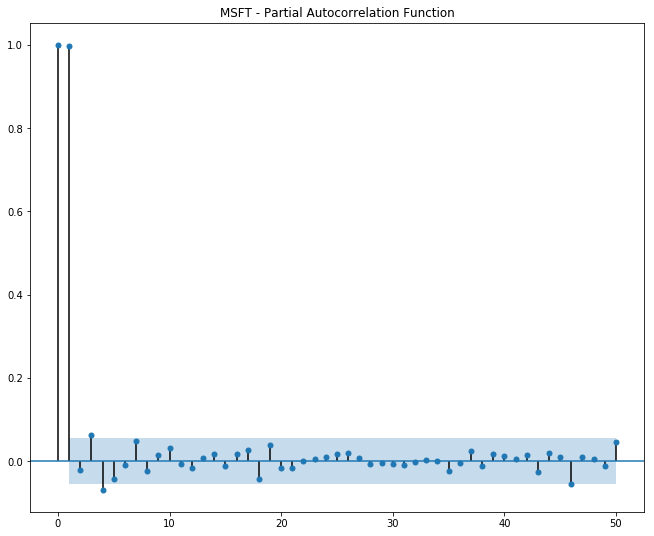

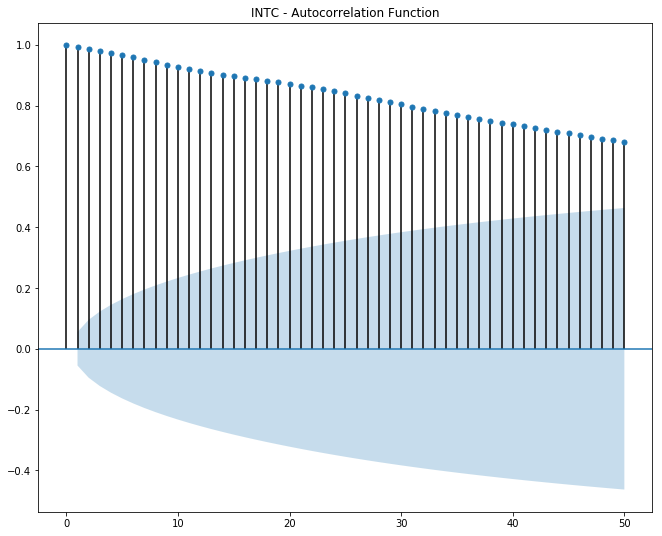

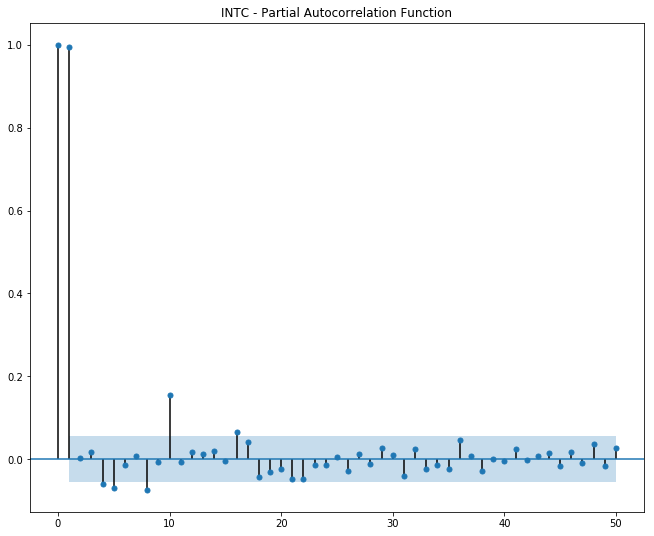

In [28]:
autocorrelation_model('MSFT', df.microsoft.dropna())
autocorrelation_model('INTC', df.intel.dropna())

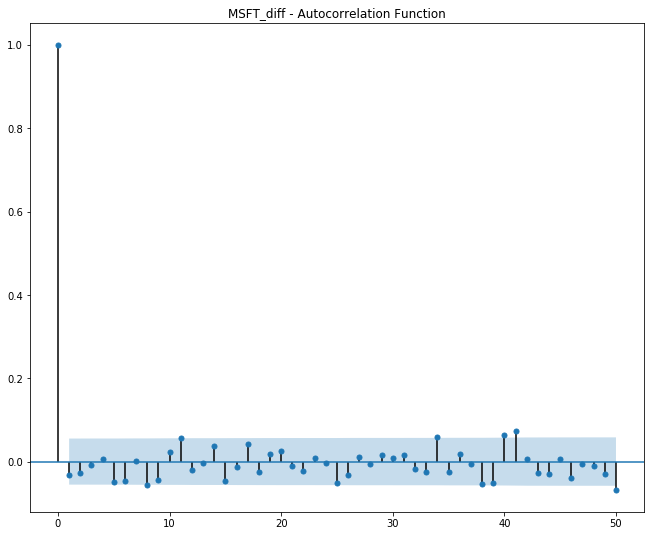

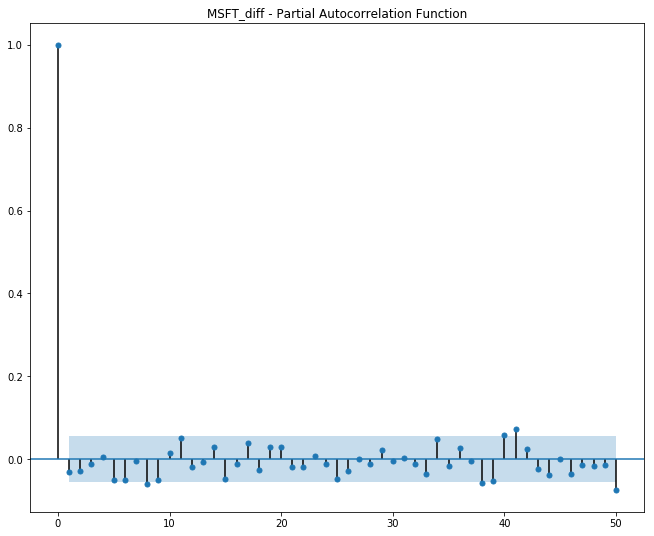

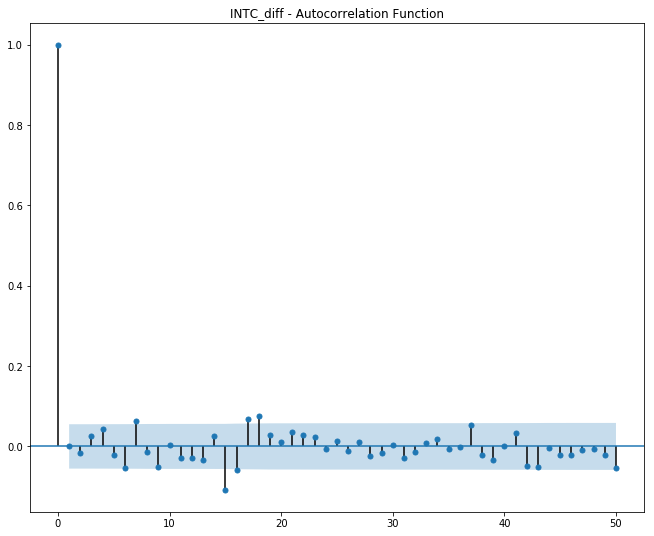

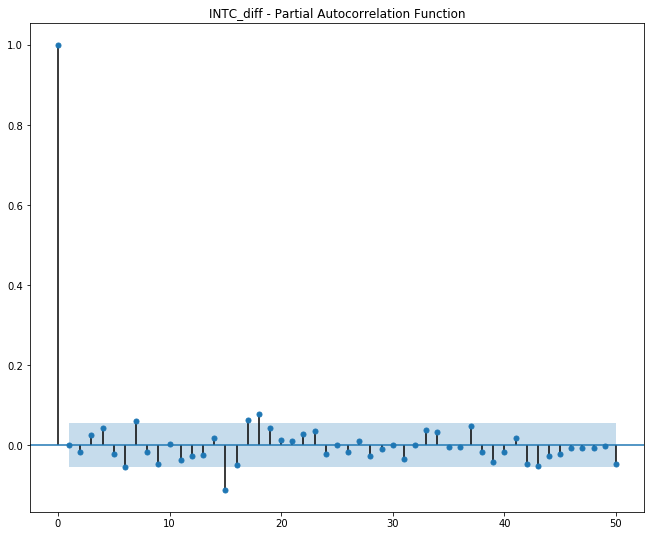

In [29]:
autocorrelation_model('MSFT_diff', df.msftdiff.dropna())
autocorrelation_model('INTC_diff', df.inteldiff.dropna())

## Implement ARIMA Gridsearch
Before proceeding with ARIMA modeling, we will apply a gridsearch that addresses the following: the combination of p, d, q in an ARIMA model that yields us the lowest MSE score and AIC scores (later, obtained using the combination yielded by the gridsearch).

In [30]:
from sklearn.metrics import mean_squared_error

def evaluate_arima(train, test, arima_order):
    history = [x for x in train]
    predictions = list()
    
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        
        y_pred = model_fit.forecast()[0]

        predictions.append(y_pred)
 
        history.append(y_pred)
    
    error = mean_squared_error(test, predictions)
    return error

def arima_gridsearch(train, test, p_vals, d_vals, q_vals):
    
    best_score = float('inf') 
    best_config = None
    for p in p_vals:
        for d in d_vals:
            for q in q_vals:
                arima_order = (p, d, q)
                try:
                    mse = evaluate_arima(train, test, arima_order)
                    if mse < best_score:
                        best_score, best_config = mse, arima_order
                    print('{}; MSE:{}'.format(arima_order, mse))
                except (ValueError, np.linalg.LinAlgError):
                    pass
    
    print('Best ARIMA configuration:', best_config)
    print('MSE:', best_score)

### Gridsearch for Microsoft (15 days)

In [31]:
arima_gridsearch(msft_train15, msft_test15, range(3), range(2), range(0, 11, 2))

(0, 0, 0); MSE:1711.4533474413272
(0, 1, 0); MSE:5.4088701427132495
(0, 1, 2); MSE:5.518255508888275
(0, 1, 4); MSE:5.797941809961018
(0, 1, 6); MSE:6.261111614192706
(0, 1, 8); MSE:6.6952220036826
(0, 1, 10); MSE:6.8267813118137015
(1, 0, 0); MSE:6.837128559399205
(1, 1, 0); MSE:5.484417920607439
(1, 1, 10); MSE:6.346594734113944
(2, 1, 0); MSE:5.50716709831124
(2, 1, 10); MSE:6.940972156000519
Best ARIMA configuration: (0, 1, 0)
MSE: 5.4088701427132495


### Gridsearch for Intel (15 days)

In [32]:
arima_gridsearch(intel_train15, intel_test15, range(3), range(2), range(0, 11, 2))

(0, 0, 0); MSE:223.56513266970856
(0, 1, 0); MSE:7.279233426069208
(0, 1, 2); MSE:7.294839171832505
(0, 1, 4); MSE:6.991286178431435
(0, 1, 6); MSE:6.941923361979922
(0, 1, 8); MSE:6.990205314961075
(0, 1, 10); MSE:6.698121881073958
(1, 0, 0); MSE:8.501331934040135
(1, 0, 2); MSE:8.496007422103714
(1, 0, 4); MSE:8.193123612330883
(1, 0, 6); MSE:8.119203335930212
(1, 0, 8); MSE:8.230379100325775
(1, 0, 10); MSE:7.934235254289527
(1, 1, 0); MSE:7.337762038477136
(1, 1, 8); MSE:6.527132280162112
(1, 1, 10); MSE:6.700539620453902
(2, 0, 0); MSE:8.537120625525464
(2, 0, 2); MSE:8.417397730256996
(2, 0, 4); MSE:8.181698747802388
(2, 0, 6); MSE:8.122454025312862
(2, 0, 8); MSE:8.258745291525578
(2, 0, 10); MSE:7.730543081171716
(2, 1, 0); MSE:7.292325621104277
(2, 1, 10); MSE:7.5103337023272
Best ARIMA configuration: (1, 1, 8)
MSE: 6.527132280162112


Microsoft's best ARIMA configuration gave us (0,1,0), with an MSE of 5.408; Intel's best was (1,1,8), which had an MSE score of 6.527. These numbers are certainly higher than we'd hope, but for the time being, we will run our modeling with these configurations. 

## ARIMA_010 for Microsoft (Results, Residuals, Predictions)

In [33]:
MSFT_ARIMA_010 = ARIMA(msft_train15, order=(0,1,0))
MSFT_ARIMA_010_fit = MSFT_ARIMA_010.fit()
print(MSFT_ARIMA_010_fit.summary())
print('Residuals Description')
print(MSFT_ARIMA_010_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:            D.microsoft   No. Observations:                 1243
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1287.737
Method:                           css   S.D. of innovations              0.682
Date:                Mon, 01 Apr 2019   AIC                           2579.475
Time:                        15:02:06   BIC                           2589.725
Sample:                             1   HQIC                          2583.330
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0504      0.019      2.604      0.009       0.012       0.088
Residuals Description
count    1.243000e+03
mean    -8.324440e-17
std      6.821235e-01
min     -4.400354e+00
25%     -3.303540e-01

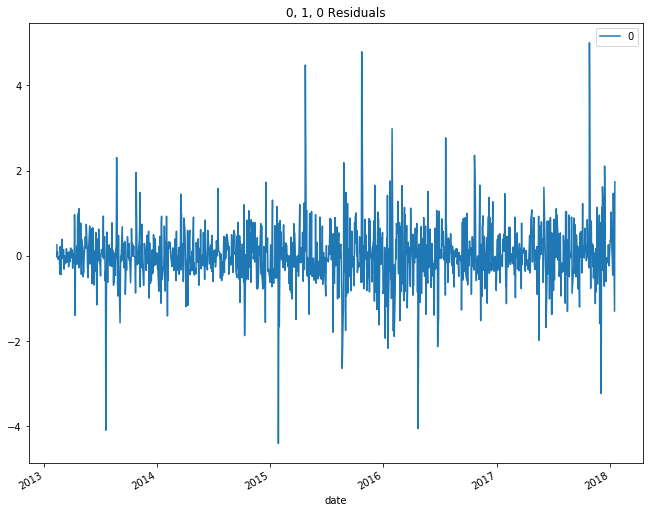

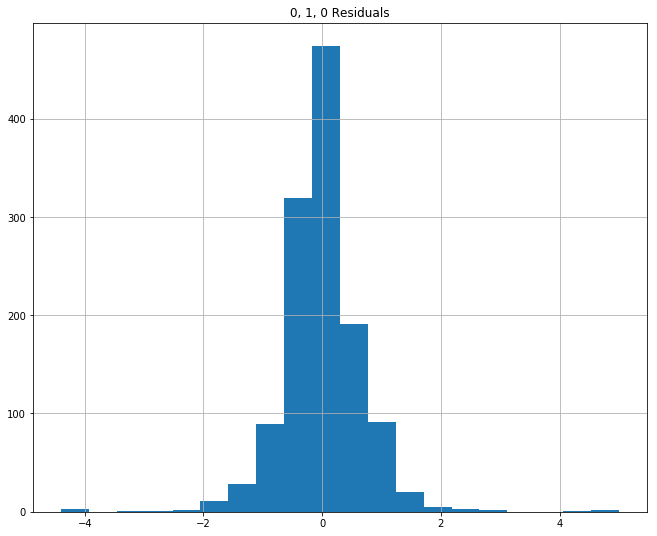

In [34]:
resid_010 = pd.DataFrame(MSFT_ARIMA_010_fit.resid)
resid_010.plot(legend=True)
plt.title('0, 1, 0 Residuals')

resid_010.hist(bins=20)
plt.title('0, 1, 0 Residuals')

plt.show()

In [35]:
def plot_predictions(name, train, test, p, d, q):
    
    arima_order = (p,d,q)
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        y_pred = model_fit.forecast()[0]
        predictions.append(y_pred)
        history.append(y_pred)

    plt.figure(figsize=(10, 5))

    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, predictions, label='Predictions')
    plt.title('{} Prediction Validation: - Full Time Series'.format(name))
    plt.ylabel('Price')
    plt.xticks(rotation=60)
    plt.legend()

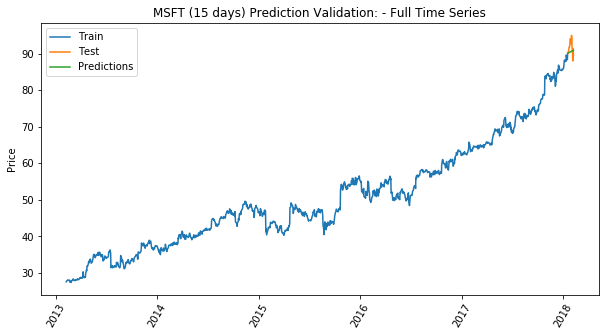

In [36]:
plot_predictions('MSFT (15 days)', msft_train15, msft_test15, 0, 1, 0)

Unfortunately, the AIC value was a lot higher than we've liked. It's worth pointing out that an arima grid search using differenced data gave us an error - had it been produced, we may not be having this problem. Still, the residual plot and histograms look largely normalized, and the predictions - although not performing well - shows an upward trend. 

## ARIMA_118 for Intel (Results, Residuals, Predictions) 

In [37]:
intel_ARIMA_118 = ARIMA(intel_train15, order=(1,1,8))
intel_ARIMA_118_fit = intel_ARIMA_118.fit()
print(intel_ARIMA_118_fit.summary())
print('Residuals Description')
print(intel_ARIMA_118_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.intel   No. Observations:                 1243
Model:                 ARIMA(1, 1, 8)   Log Likelihood                -737.576
Method:                       css-mle   S.D. of innovations              0.438
Date:                Mon, 01 Apr 2019   AIC                           1497.151
Time:                        15:02:13   BIC                           1553.530
Sample:                             1   HQIC                          1518.352
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0190      0.012      1.564      0.118      -0.005       0.043
ar.L1.D.intel     0.8150      0.202      4.041      0.000       0.420       1.210
ma.L1.D.intel    -0.8287      0.203     

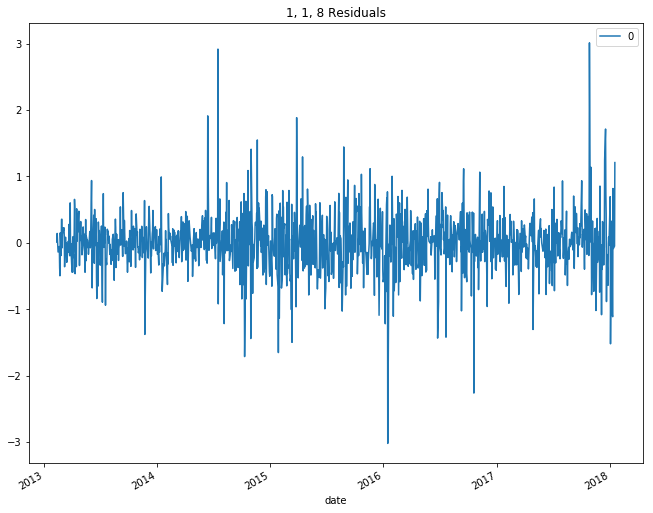

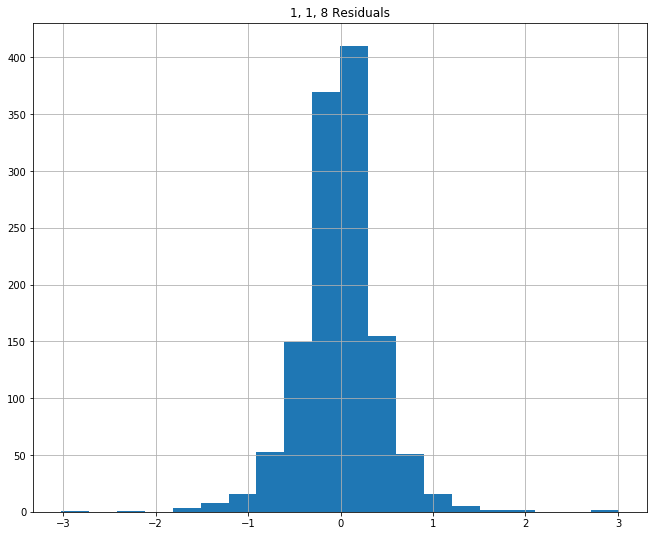

In [38]:
resid_118 = pd.DataFrame(intel_ARIMA_118_fit.resid)
resid_118.plot(legend=True)
plt.title('1, 1, 8 Residuals')

resid_118.hist(bins=20)
plt.title('1, 1, 8 Residuals')

plt.show()

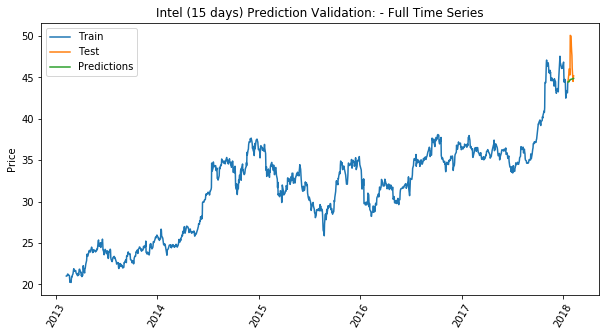

In [39]:
plot_predictions('Intel (15 days)', intel_train15, intel_test15, 1, 1, 8)

Similar observations could be made here as with the Microsoft modeling - the prediction shows a slight upward trend, residuals appear normal, etc. The AIC score for Intel is noticeably smaller, but still far too big than the project would've hoped. These tests will be re-run when the gridsearch error for differenced data is addressed. In both instances, the predictions have been low biased.

# F. Time Series w/ Facebook Prophet

Let's compare what we have with a time series forecasting tool called Facebook Prophet! Among FBprophet's many qualities, it captures hourly (let alone weekly and yearly) data with provided data of a few months at least. It is a package that's being promoted to non-veteran data scientists hoping to perform low-cost forecasts. Let's take a look. 

## Facebook Prophet Model: Microsoft

In [40]:
# we are gonna re-clean this dataset for Prophet
from fbprophet import Prophet

df_ph = pd.read_csv('all_stocks_5yr.csv')
df_ph.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [41]:
df_microsoft = df_ph[df_ph['Name']=='MSFT']
df_intel = df_ph[df_ph['Name']=='INTC']
df_microsoft.loc[:, 'date'] = pd.to_datetime(df_microsoft.loc[:,'date'], format="%Y/%m/%d")
df_intel.loc[:, 'date'] = pd.to_datetime(df_intel.loc[:,'date'], format="%Y/%m/%d")

In [42]:
m = Prophet()
ph_msft = df_microsoft.drop(['open', 'high', 'low','volume', 'Name'], axis=1)
ph_msft = ph_msft.rename(columns={'date': 'ds', 'close': 'y'})
ph_msft.head()

,ds,y
390198,2013-02-08,27.55
390199,2013-02-11,27.86
390200,2013-02-12,27.88
390201,2013-02-13,28.03
390202,2013-02-14,28.04


In [43]:
ph_intel = df_intel.drop(['open', 'high', 'low','volume', 'Name'], axis=1)
ph_intel = ph_intel.rename(columns={'date': 'ds', 'close': 'y'})
ph_intel.head()

,ds,y
298957,2013-02-08,21.00
298958,2013-02-11,21.03
298959,2013-02-12,21.19
298960,2013-02-13,21.25
298961,2013-02-14,21.23


In [44]:
m.fit(ph_msft)
future_prices = m.make_future_dataframe(periods=15)
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1269,2018-02-18,90.171850,88.411093,91.984374
1270,2018-02-19,89.262805,87.306036,91.156283
1271,2018-02-20,89.276733,87.457334,91.125179
1272,2018-02-21,89.352769,87.521760,91.181851
1273,2018-02-22,89.368999,87.512402,91.183340


We now have the forecasted data for Microsoft - let's visualize it with Facebook Prophet. 
The graphs below represent the 15-day forecast juxtaposed with historical performance, weekly/yearly/general trends, and a close-up graph of the 15-day forecast, in that order. 

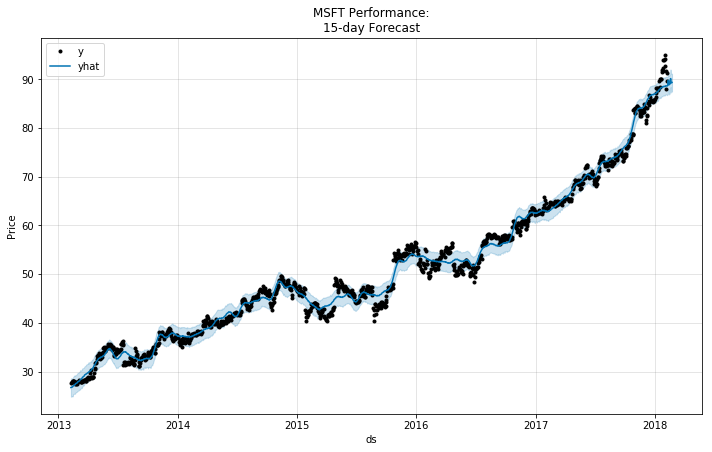

In [45]:
m.plot(forecast)
plt.title('MSFT Performance:\n15-day Forecast')
plt.ylabel('Price')
plt.legend()
plt.show()

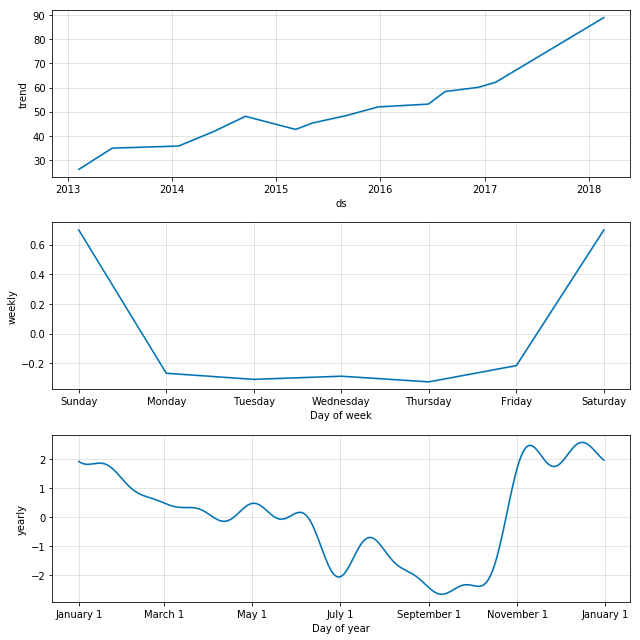

In [46]:
m.plot_components(forecast)
plt.show()

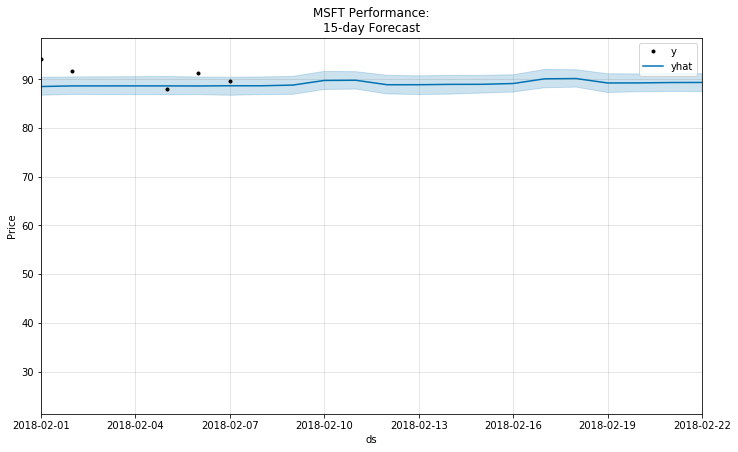

In [47]:
m.plot(forecast)
plt.title('MSFT Performance:\n15-day Forecast')
plt.ylabel('Price')
plt.xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 22)])
plt.legend()
plt.show()

We see that while the trend of the Microsoft stock prices are upward, its performance over the next 15-days mostly stays flat. Oddly enough, the predicted values were higher for the weekends than for trading days; this suggests there is "noise" or additional values that the model is picking up on, as the dataset had no trading values for the weekend. 

## Validation for ph_msft

In [48]:
train = ph_msft[:-15]
test = ph_msft[-15:]
outcome = forecast[['ds', 'yhat']].merge(test, on='ds')
print('Mean-sq Error:', mean_squared_error(outcome.y, outcome.yhat))

outcome['residual'] = outcome['y'] - outcome['yhat']

Mean-sq Error: 15.094604108653025


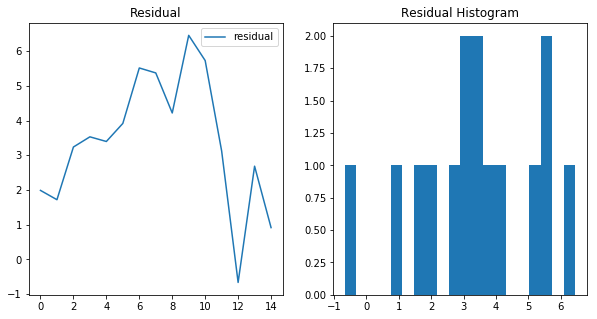

In [49]:
plt.figure(figsize=(10,5))

plt.subplot(121)
outcome.residual.plot(legend=True)
plt.title('Residual')

plt.subplot(122)
plt.hist(outcome.residual, bins=20)
plt.title('Residual Histogram')

plt.show()

Neither the residual nor the MSE score suggest that the model is a good one. The residual histogram shows that the error isn't normally distributed, and barring day 12 of the 15-day period, the model consistently overpredicts. The MSE score is also a lot higher than we'd like, especially when compared to the ARIMA model for Microsoft.  

## Facebook Prophet Model: Intel

We will now do the same with Intel. 

In [50]:
i = Prophet()
i.fit(ph_intel)
future_prices_intel = i.make_future_dataframe(periods=15)
forecast = i.predict(future_prices_intel)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1269,2018-02-18,43.639212,41.869008,45.252816
1270,2018-02-19,43.605054,41.712817,45.339949
1271,2018-02-20,43.650913,41.936388,45.371553
1272,2018-02-21,43.656472,41.813832,45.427040
1273,2018-02-22,43.610062,41.911596,45.489158


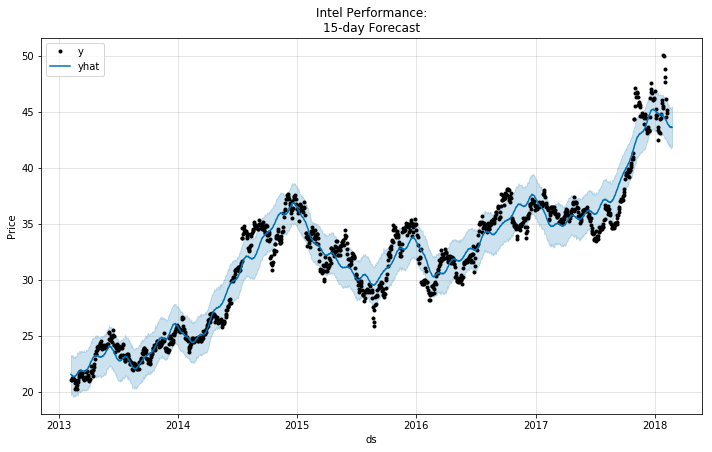

In [51]:
i.plot(forecast)
plt.title('Intel Performance:\n15-day Forecast')
plt.ylabel('Price')
plt.legend()
plt.show()

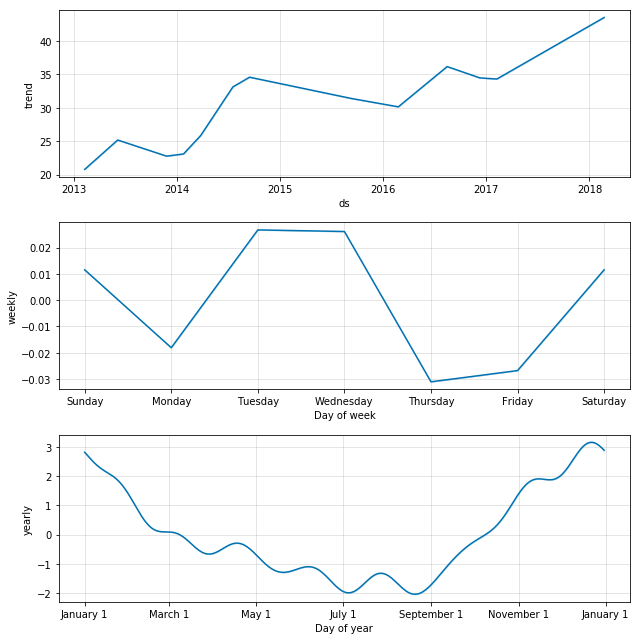

In [52]:
i.plot_components(forecast)
plt.show()

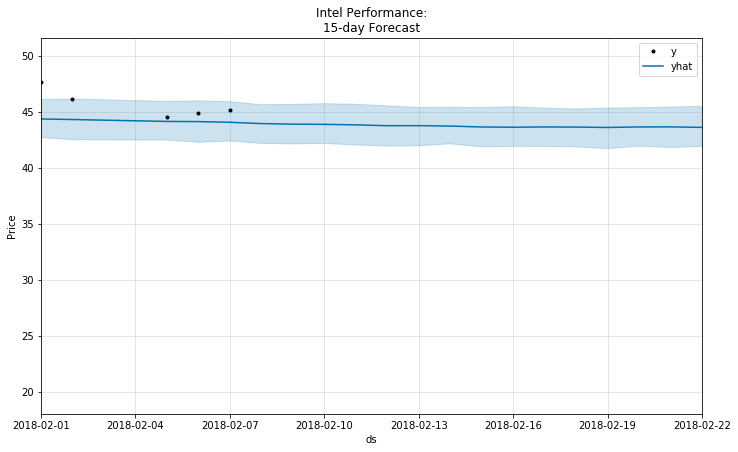

In [53]:
i.plot(forecast)
plt.title('Intel Performance:\n15-day Forecast')
plt.ylabel('Price')
plt.xlim([datetime.date(2018, 2, 1), datetime.date(2018, 2, 22)])
plt.legend()
plt.show()

## Validation for ph_intel

In [54]:
i_train = ph_intel[:-15]
i_test = ph_intel[-15:]
i_outcome = forecast[['ds', 'yhat']].merge(i_test, on='ds')
print('Mean-sq Error:', mean_squared_error(i_outcome.y, i_outcome.yhat))

i_outcome['residual'] = i_outcome['y'] - i_outcome['yhat']

Mean-sq Error: 7.413242150188759


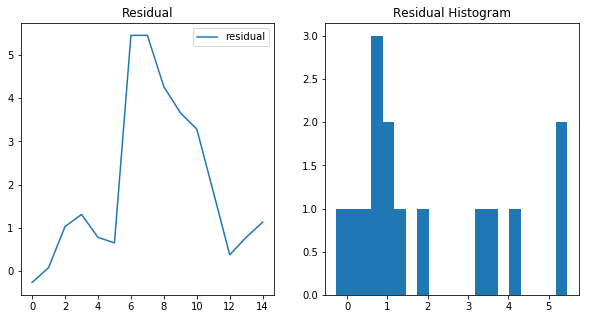

In [55]:
plt.figure(figsize=(10,5))

plt.subplot(121)
i_outcome.residual.plot(legend=True)
plt.title('Residual')

plt.subplot(122)
plt.hist(i_outcome.residual, bins=20)
plt.title('Residual Histogram')

plt.show()

In general, similar problems emerged with Intel's Facebook prophet model - high MSE score, non-normally distributed residual histogram (even more so than Microsoft), and over-prediction. Some observations - Intel's MSE score was much lower at 7.4, and its trends show predicted values were highest on Tuesday and Wednesday, and lowest on Thursday and Friday. Like Microsoft, this FB prophet model tended to overpredict - with the exception of the first day of forecasts (Feb. 8). 

# Conclusion

Based on our modeling process and evaluation of our models, we can see that ARIMA models for Microsoft and Intel performed better than their FB prophet counterparts. Both were, however, flawed by a dataset that might need further differencing. The reason we decided to proceed with the undifferenced dataset is due to our ARIMA Gridsearch returning an error for differenced data. We will be looking into this and making changes going forward. 

This has affected the Mean-squared error scores and residual normality for both of our models, and has certainly affected the quality of our predictor. However, this is a good start to an important application that aims to provide reliable short-term stock predictions for companies/individuals that wish to assess market fluctuations and competition. 

The "big fixes" for the product going forward include - 
1) Lowering the existing Mean-Sq. Error Scores
2) Tweaking the differenced data so that the differenced data (deemed stationary after testing) doesn't return an error on the ARIMA Grid Search, and 
3) Lower AIC (Akaike Information Criterion) scores, should differenced data not provide us with one that's much, much lower. This is the score that estimates relative amount of information loss by a model. Thus, lesser the loss = higher the quality